Advanced Lane Finding (Project description)

Udacity - Self-Driving Car NanoDegree

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.
Creating a great writeup:

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references. You should include images in your writeup to demonstrate how your code works with examples.

All that said, please be concise! We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :).

You're not required to use markdown for your writeup. If you use another method please just submit a pdf of your writeup.
The Project

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

Import all the libraries that are necessary 

In [232]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

The following is function that read all the camera calibration chess board images and use the OpenCV function to see if it is possible finding all the chess board corners. The default input for column and row are 9 and 6 respectivitly. The default input was selected simply because the chess boards in all the images files are 6 x 9. The function return the object points (3D points in real world space) and the image points (2D points in image plane).

In [233]:
import glob

def getObjAndImgPointsFromChessBoardImages(col = 9, row = 6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((col*row,3), np.float32)
    objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (col,row), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

I define a function that Undistort an image. The function should take care of the all minor detail such as calibrate a camera.

In [234]:
objpoints, imgpoints = getObjAndImgPointsFromChessBoardImages()

def UndistortImage(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


Test on a raw image

In [235]:
# Create a function that allow us to display two images in a row for side by side comparsion
def CompareImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=20)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=20)

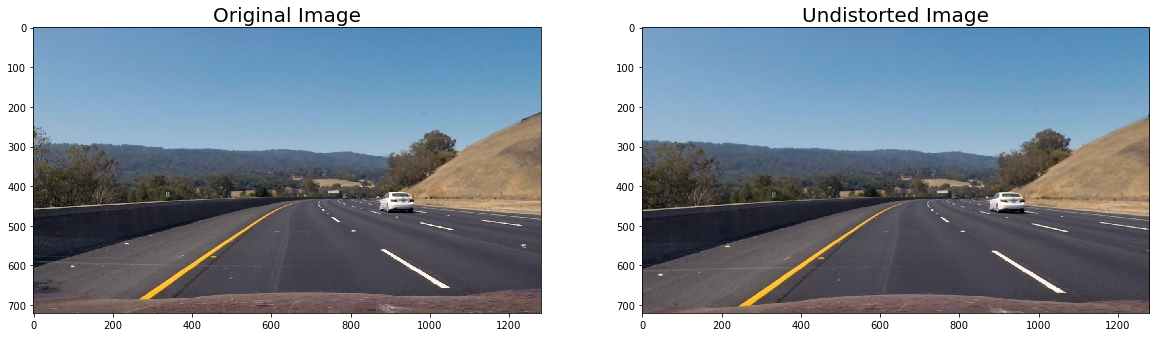

In [236]:
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test3.jpg')
dst = UndistortImage(img)

CompareImage(img, dst, 'Original Image', 'Undistorted Image')

Here is the function that obtain the S channel of the HLS color spacing. The default threshold of 120 and 255 were choosen.

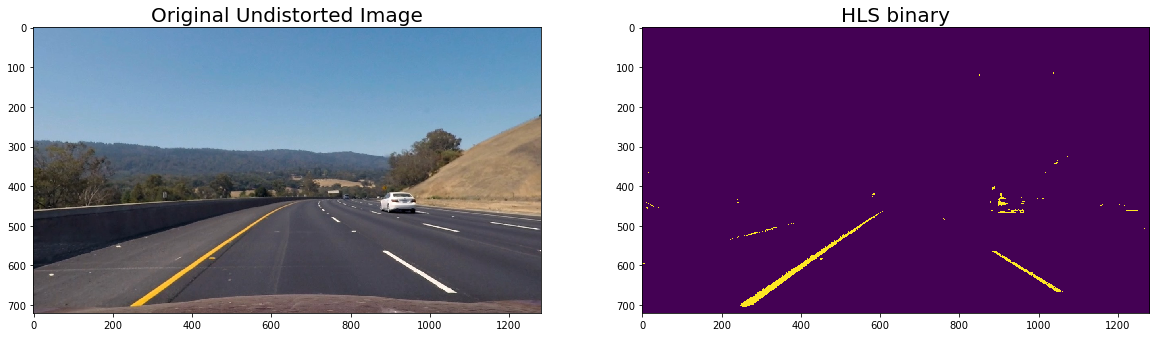

In [237]:
def hls_select(img, thresh=(120, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(dst)
CompareImage(dst, hls_binary, 'Original Undistorted Image', 'HLS binary')

Here is the function that do X gradient with Sobel Operator on an image. I use only X gradient because I think that X Gradient do a better job for lane detection without adding too much noise.

In [238]:
def X_gradient(img, thresh=(20, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

    abs_derivative = np.absolute(derivative)
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

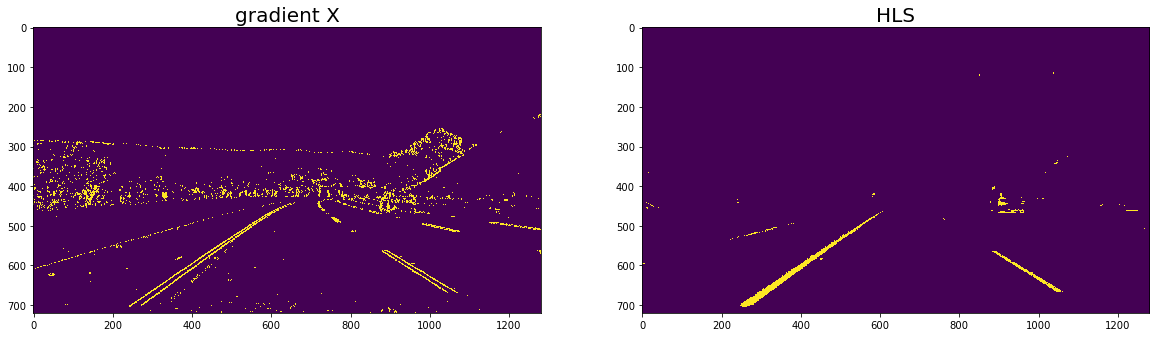

In [239]:
gradx = X_gradient(dst)
CompareImage(gradx, hls_binary, 'gradient X', 'HLS')

The following function combine both the HLS and Sobel Operator of X gradient onto an image for lane detection. Now, it is very obvious that combine X gradient along with HLS S channel output give us more detail of the lane line.

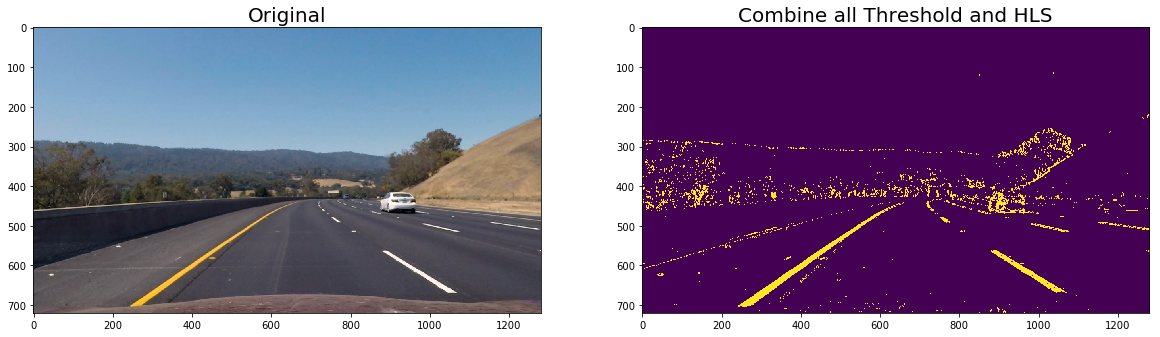

In [240]:
def CombineAllThresholdsAndHLS(img):
    hls_binary = hls_select(img)
    threshold = X_gradient(dst)
    binary_output = np.zeros_like(threshold)
    binary_output[(hls_binary == 1) | (threshold == 1)] = 1    

    return binary_output

final = CombineAllThresholdsAndHLS(dst)
CompareImage(dst, final, 'Original', 'Combine all Threshold and HLS')

The following is getPerspectiveSrcDst function that return two arrays of four points, the source points and the destination points for image perspective tranformation.

To do perspective tranform, we simply transform the image as front view of the camera to the bird view of the road. The idea is that we find four points from the original image, then define the four destination points base on how we want to transform the image. And this function (getPerspectiveSrcDst) is to find the source and destination points so that we can call the OpenCV cv2.warpPerspective to transform the image into bird view image and allow us to find the lane line of the road.
To get the four points for the source, we can simply draw the associated trapezoidal shape where we obtain this trapezoid from the input image of the lane line that we detected. However, things are not always perfect. the lane line that we detected may be a dash line and therefore we may not form a perfect trapezoid. 

The way how I implement it is as following:

Find the area that I am interested in on the image. In this case, it is the lane line, so I try to mask away the rest of the image but only preserve the lower region of the triangle image (just like Project One)

Then I detected all the straight lines that I can and I know I have more than one straight lines (we must have at least two lines for a lane). The OpenCV function HoughLinesP function was used in this case. Next, I find the longest line with the positive slop and a longest line with a negative slop. Since I want a trapezoid, I use the line formula I just found on each lane line and select the four trapezoid points as my source.

For the destination point, I know that the final image that I want is a bird view image. Therefore I know the two line that I have must be parallel. Meaning that two end points on my left lane line, the upper point x position of the point must be transform to the x position of the lower point x position. The same is also true for my right lane line.

In [241]:
def getPerspectiveSrcDst(img, rho = 10, theta = 3*np.pi/180, threshold = 12, 
                min_line_len = 40, max_line_gap = 5):

    # add region of interest
    shape = img.shape
    vertices = np.array([[(70, shape[0]), (shape[1]/2, shape[0]*0.55), (shape[1]-70, shape[0])]], dtype=np.int32)
    ignore_mask_color = 255
    mask = np.zeros_like(img)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    img = cv2.bitwise_and(img, mask)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    posSlop_len = 0
    negSlop_len = 0
    pos_m = None
    pos_b = None
    neg_m = None
    neg_b = None
    PosLine = None
    NegLine = None
    
    for line in lines:
        for x1, y1, x2, y2 in line:
#            print("lines: ", x1, y1, x2, y2)
            m = (float)(y2-y1)/(float)(x2-x1)
            b = y1 - m*x1
            length = (y2-y1)*(y2-y1) + (x2-x1)*(x2-x1)
            if m > 0.3 and m < 3 and length > posSlop_len:
                posSlop_len = length
                PosLine = line
                pos_m = m
                pos_b = b
            if m < -0.3 and m > -3 and length > negSlop_len:
                negSlop_len = length
                NegLine = line
                neg_m = m
                neg_b = b
                
    # Now we found the two lines and the associated m and b value for the y=mx+b linear equation,
    # we use the two lines equation to define our four source points

    # predefined the y value of the four source point.
    PosLine[0][1] = NegLine[0][1] = 700 
    PosLine[0][3] = NegLine[0][3] = 550
    
    # use the y=mx+b formula to find the associated x value for each point.
    PosLine[0][0] = int((PosLine[0][1] - pos_b)/pos_m)
    PosLine[0][2] = int((PosLine[0][3] - pos_b)/pos_m)
    NegLine[0][0] = int((NegLine[0][1] - neg_b)/neg_m)
    NegLine[0][2] = int((NegLine[0][3] - neg_b)/neg_m)
#    print ("Pos: ", PosLine, "pos_m: ", pos_m, pos_b)
#    print ("Neg: ", NegLine, "neg_m: ", neg_m, neg_b)
    src_point = np.float32([[PosLine[0][0], PosLine[0][1]],
                            [PosLine[0][2], PosLine[0][3]],
                            [NegLine[0][0], NegLine[0][1]],
                            [NegLine[0][2], NegLine[0][3]],
                           ])
    
#    print(src_point)
    dst_point = np.float32([[PosLine[0][0], PosLine[0][1]],
                            [PosLine[0][0], PosLine[0][3]],
                            [NegLine[0][0], NegLine[0][1]],
                            [NegLine[0][0], NegLine[0][3]],
                           ])
#    print(dst_point)
    return src_point, dst_point

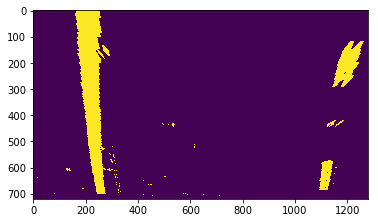

In [242]:

src_p, dst_p = getPerspectiveSrcDst(final)
def WarpImg(img, src_p, dst_p):
    M = cv2.getPerspectiveTransform(src_p, dst_p)
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

warped = WarpImg(final, src_p, dst_p)
plt.imshow(warped)

Here is the histogram of the lower region of the warped image. We can basically start from here for the sliding windows to fit the second order polynomial function for both left and right lane lines

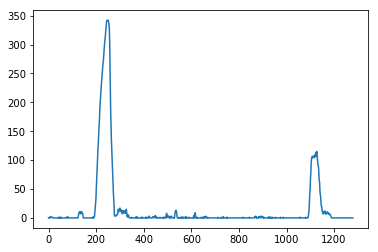

In [243]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [244]:
def draw_and_fit_lines(warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img


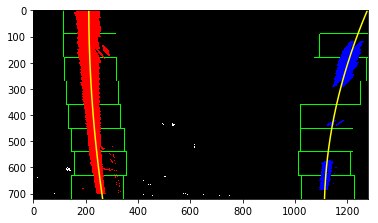

In [245]:
left_fit, right_fit, out_img = draw_and_fit_lines(warped)

def draw_line_windowing_fit(img, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

draw_line_windowing_fit(out_img, left_fit, right_fit)   

In [246]:
def draw_and_fit_lines_Cont(warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
left_fit, right_fit = draw_and_fit_lines_Cont(warped, left_fit, right_fit)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


In [247]:
def curvature(left_fit, right_fit, binary_warped, print_data = True):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_data == True:
    #Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')

    return left_curverad, right_curverad, center


(720, 0)

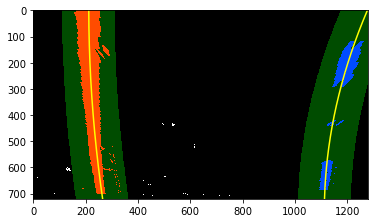

In [248]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


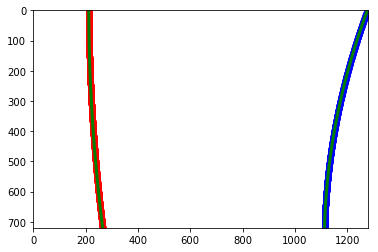

In [249]:

# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
#leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                              for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                for y in ploty])

#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
#left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 5
plt.plot(left_fitx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(right_fitx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [250]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


5261.65104447 1817.4301413


In [251]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


TypeError: expected x and y to have same length

In [194]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)


NameError: name 'Minv' is not defined